# Testing the Simulation Functions

The Hawkes module implements the multivariate Hawkes marked point process. We assume an exponential decay function is used to improve the numerical computation of the intensity function [Liniger, 2012]. Here, we test the Hawkes point process simulation to simulate the clustering of events and their associated marks.

Importing the dependencies:

In [9]:
import hawkes
import markDistributions as md
import numpy as np
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams

Setting number of point process components and number of points to simulate:

In [10]:
d=2
numPoints=200+2000

Setting pre-fitted mark distribution and impact function parameters, obtained from [Liniger, 2012]:

In [11]:
eta=[0.021,0.029]
Q=[0.61,0.16,0.6,0.06]
alpha=[0.005]*d
mu=[3.6,4.2]
rho=[5.6,7.2]
alph=[0.47,1.1]
beta=[0.22,0.0]

mdParam1=[alph[0],beta[0]]
mdParam2=[alph[1],beta[1]]

param = []
param.extend(eta)
param.extend(Q)
param.extend(alpha)
param.extend(mdParam1)
param.extend(mdParam2)

markparam = [[mu[0],rho[0]],[mu[1],rho[1]]]

Instantiating a multivariate Hawkes point process object and set the parameters as above:

In [12]:
hp = hawkes.Hawkes(d=d)
hp.setParam(param)
hp.setMarkDistParam(markparam)

Also checking if model is well-defined, where the spectral radius Spr(Q) < 1:

In [13]:
print('Spr(Q)='+str(hp.ibParam.getSpectralRadius()))

Spr(Q)=0.74927647773


Simulate a Hawkes marked point process:

In [14]:
simulatedPoints, simulatedIntensities = hp.simulate(numPoints)

Checking the intervals between each simulated even points to roughly and qualitatively determine if there are clusterings (i.e. we're looking for a long interval followed by periods of short intervals):

Also, plotting the intensities during each event occurence:

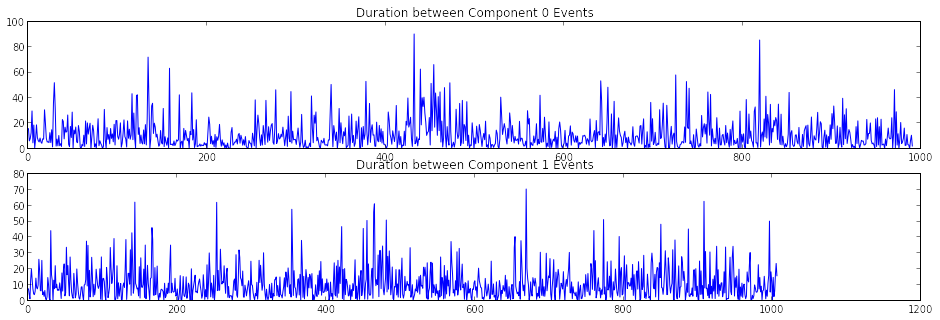

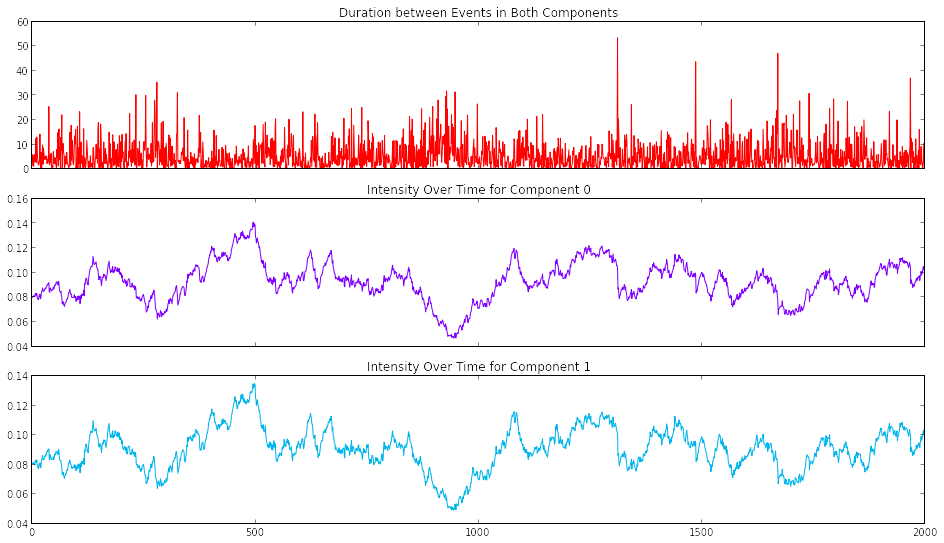

In [15]:
s0 = simulatedPoints[0][simulatedPoints[1]==0]
s1 = simulatedPoints[0][simulatedPoints[1]==1]
intervals0 = s0[1:] - s0[:-1]
intervals1 = s1[1:] - s1[:-1]
intervals = simulatedPoints[0][1:] - simulatedPoints[0][:-1]

rcParams['figure.figsize'] = 16, 5
f, axarr = plt.subplots(2)
axarr[0].plot(np.arange(len(intervals0)), intervals0)
axarr[0].set_title('Duration between Component 0 Events')
axarr[1].plot(np.arange(len(intervals1)), intervals1)
axarr[1].set_title('Duration between Component 1 Events')
plt.show()

rcParams['figure.figsize'] = 16, 9
f, axarr = plt.subplots(3, sharex=True)
colors = cm.rainbow(np.linspace(0, 1, 5))
axarr[0].plot(np.arange(len(intervals)), intervals, color=colors[4])
axarr[0].set_title('Duration between Events in Both Components')
for i,c in zip(xrange(1,3), colors):
    axarr[i].plot(simulatedIntensities[:,i-1], color=c)
    axarr[i].set_title('Intensity Over Time for Component ' + str(i-1))
plt.show()

Visualizing the actual intensity over-time (grabbing only some consecutive n-2 event occurences, and imposing reduced resolution, due to memory limitations):

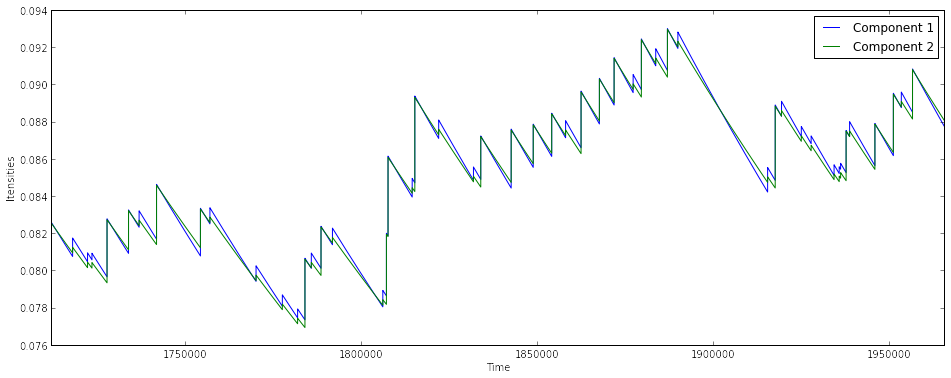

In [16]:
n = 52
res = 1.0e3

t_grab = np.asarray(simulatedPoints[0][1:n]*res,dtype=int)
j_grab = simulatedPoints[1][1:n]
x_grab = simulatedPoints[2][1:n]

start, end = t_grab[0]+1, t_grab[-1]+random.randint(0,10000)

iter_t = iter(t_grab)
iter_j = iter(j_grab)
iter_x = iter(x_grab)

def next_all():
    return iter_t.next(),iter_j.next(),iter_x.next()

t_prev,j_prev,x_prev = next_all()
t_next,j_next,x_next = next_all()

intensity_prev = simulatedIntensities[0,0]
intensities = ([],[])
for i in xrange(start, end):
    if i == t_next:
        for k in xrange(2):
            intensity_curr = hp.Intensity(j=k,t=i/res,_tjx=(t_prev/res,j_prev,x_prev),_intensity=intensity_prev)
            intensities[k].append(intensity_curr)
            if k == j_next:
                temp = intensity_curr
        intensity_prev = temp
        t_prev,j_prev,x_prev = t_next,j_next,x_next
        try:
            t_next,j_next,x_next = next_all()
        except StopIteration:
            pass
    else:
        for k in xrange(2):
            intensity_curr = hp.Intensity(j=k,t=i/res,_tjx=(t_prev/res,j_prev,x_prev),_intensity=intensity_prev)
            intensities[k].append(intensity_curr)

rcParams['figure.figsize'] = 16, 6
plt.plot(xrange(start,end),intensities[0],label='Component 1')
plt.plot(xrange(start,end),intensities[1],label='Component 2')
plt.xlim([start,end])
plt.xlabel('Time')
plt.ylabel('Itensities')
plt.legend()
plt.show()

In the figure above, cross-excitation can be seen. An event occurence in one component excites the other component, resulting in an intensity increase of the other. Self-excitation is evident as well, by the narrow jagged peaks.

Cross-excitation is represented in the branching matrix $Q$:

$$ Q = \begin{pmatrix}
  \theta_{11} & \theta_{12} \\
  \theta_{21} & \theta_{22} 
 \end{pmatrix} $$

where currently, $$\theta_{11}=0.61, \theta_{12}=0.16, \theta_{21}=0.6, \theta_{22}=0.06$$

$\theta_{ij}$ are the branching coefficients [Liniger, 2012] of the multivariate Hawkes process. Essentially, $\theta_{ij}$ is mean number of descendant processes of component $i$ due to an event occuring in component $j$. In our example, an event in component $2$ has a mean $\theta_{12}=0.16$ descendant processes in component $1$.

Comparing $\theta_{11}=0.61$ and $\theta_{22}=0.06$, we expect to not see as much narrow jagged peaks led by component 2 events compared to that of component 1.

This can be illustrated further by toying with the branching coefficients:

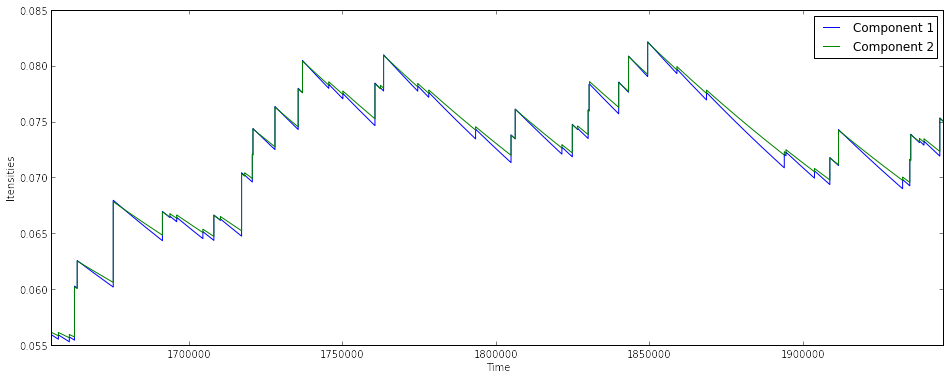

In [17]:
Q=[0.61,0.016,0.6,0.06]
hp.ibParam.setParam(eta,Q)
simulatedPoints, simulatedIntensities = hp.simulate(numPoints)

n = 52
res = 1.0e3

t_grab = np.asarray(simulatedPoints[0][1:n]*res,dtype=int)
j_grab = simulatedPoints[1][1:n]
x_grab = simulatedPoints[2][1:n]

start, end = t_grab[0]+1, t_grab[-1]+random.randint(0,10000)

iter_t = iter(t_grab)
iter_j = iter(j_grab)
iter_x = iter(x_grab)

def next_all():
    return iter_t.next(),iter_j.next(),iter_x.next()

t_prev,j_prev,x_prev = next_all()
t_next,j_next,x_next = next_all()

intensity_prev = simulatedIntensities[0,0]
intensities = ([],[])
for i in xrange(start, end):
    if i == t_next:
        for k in xrange(2):
            intensity_curr = hp.Intensity(j=k,t=i/res,_tjx=(t_prev/res,j_prev,x_prev),_intensity=intensity_prev)
            intensities[k].append(intensity_curr)
            if k == j_next:
                temp = intensity_curr
        intensity_prev = temp
        t_prev,j_prev,x_prev = t_next,j_next,x_next
        try:
            t_next,j_next,x_next = next_all()
        except StopIteration:
            pass
    else:
        for k in xrange(2):
            intensity_curr = hp.Intensity(j=k,t=i/res,_tjx=(t_prev/res,j_prev,x_prev),_intensity=intensity_prev)
            intensities[k].append(intensity_curr)

rcParams['figure.figsize'] = 16, 6
plt.plot(xrange(start,end),intensities[0],label='Component 1')
plt.plot(xrange(start,end),intensities[1],label='Component 2')
plt.xlim([start,end])
plt.xlabel('Time')
plt.ylabel('Itensities')
plt.legend()
plt.show()

Reducing $\theta_{12}$ by a factor of 10, it can be noticed that the frequency at which component 2 induces cross-excitation is reduced.